In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "6" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "6" # export OPENBLAS_NUM_THREADS=4
os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6

In [2]:
from matplotlib import pyplot as plt

import torch

from omegaconf import OmegaConf
from ase.visualize.plot import plot_atoms
from ase import Atoms
from schnetpack import properties
import schnetpack.transform as trn
from schnetpack.datasets import QM9
from tqdm import tqdm
import ase

from morered.datasets import QM9Filtered, QM7X
from morered.noise_schedules import PolynomialSchedule
from morered.processes import VPGaussianDDPM
from morered.utils import scatter_mean, check_validity, generate_bonds_data, batch_center_systems
from morered.sampling import DDPM, MoreRedJT, MoreRedAS, MoreRedITP

# Helper functions

In [3]:
def plot_batch_molecules(batch):
    n_cols = len(batch[properties.idx_m].unique())
    n_rows = 1

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
    axs = axs.flatten()

    for i, ax in enumerate(axs):
        mask = batch[properties.idx_m] == i
        mol = Atoms(numbers=batch[properties.Z][mask], positions=batch[properties.R][mask])

        plot_atoms(mol, ax)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Paths

In [4]:
# path to store the dataset as ASE '.db' files
split_file_path = "split.npz"

# model path
models_path = "../models"

# Load models

In [5]:
# MoreRed-JT: joint denoiser and time predictor
morered_jt = torch.load(os.path.join(models_path, "qm9_morered_jt.pt"), map_location="cpu")

# MoreRed-AS, MoreRed-ITP and plain DDPM use the same denoier model
ddpm_denoiser = torch.load(os.path.join(models_path, "qm9_ddpm.pt"), map_location="cpu")

# Seperate model for time prediction for MoreRed-AS and MoreRed-ITP
time_predictor = torch.load(os.path.join(models_path, "qm9_time_predictor.pt"), map_location="cpu")

# Define sampler

In [6]:
# define the noise schedule
noise_schedule = PolynomialSchedule(T=1000, s=1e-5, dtype=torch.float64, variance_type="lower_bound")

# define the forward diffusion process
diff_proc = VPGaussianDDPM(noise_schedule, noise_key="eps", invariant=True, dtype=torch.float64)

In [7]:
ddpm_sampler = DDPM(
    diff_proc,
    ddpm_denoiser,
    time_key="t",
    noise_pred_key="eps_pred",
    cutoff=5.,
    recompute_neighbors=False,
    save_progress= True,
    progress_stride = 1,
    results_on_cpu = True,
)

In [8]:
mrd_jt_sampler = MoreRedJT(
    diff_proc,
    morered_jt,
    noise_pred_key="eps_pred",
    time_key="t",
    time_pred_key="t_pred",
    convergence_step=0,
    cutoff=5.,
    recompute_neighbors=False,
    save_progress= True,
    progress_stride = 1,
    results_on_cpu = True
)

In [9]:
mrd_as_sampler = MoreRedAS(
    diff_proc,
    ddpm_denoiser,
    time_predictor,
    noise_pred_key="eps_pred",
    time_pred_key="t_pred",
    time_key="t",
    cutoff=5.,
    recompute_neighbors=False,
    save_progress= True,
    progress_stride = 1,
    results_on_cpu = True
)

In [10]:
mrd_itp_sampler = MoreRedITP(
    diff_proc,
    ddpm_denoiser,
    time_predictor,
    noise_pred_key="eps_pred",
    time_pred_key="t_pred",
    time_key="t",
    cutoff=5.,
    recompute_neighbors=False,
    save_progress= True,
    progress_stride = 1,
    results_on_cpu = True
)

# Define data loader

Define paths

In [11]:
tut_path = "./tut"

In [12]:
os.makedirs(tut_path, exist_ok=True)

Define data input transformations

In [13]:
transforms=[
    trn.CastTo64(),
    trn.SubtractCenterOfGeometry(),
]

Define dataset

QM9

In [14]:
# path to store the dataset as ASE '.db' files
datapath = os.path.join(tut_path, "qm9.db")

In [15]:
data = QM9Filtered(
    datapath=datapath,
    batch_size=8,
    remove_uncharacterized=True,
    num_train=128,
    num_val=128,
    num_test=128,
    transforms=transforms,
    num_workers=2,
    pin_memory=False,
)

QM7X

NOTE! QM7-X is large. Therefore, it takes time to download the dataset and prepare it

In [16]:
# path to store the dataset as ASE '.db' files
# datapath = os.path.join(tut_path, "qm7x.db")

In [17]:
# data = QM7X(
#     datapath=datapath,
#     only_equilibrium=False,
#     batch_size=8,
#     transforms=transforms,
#     num_train=128,
#     num_val=128,
#     num_test=128,
#     num_workers=2,
#     pin_memory=False,
#     load_properties=["rmsd"],
# )

Prepare dataset

In [18]:
# prepare and setup the dataset
data.prepare_data()
data.setup()

# Relaxing batches of diffused data

Load a batch

In [26]:
# train split here is not the same as during training
batch = next(iter(data.train_dataloader()))

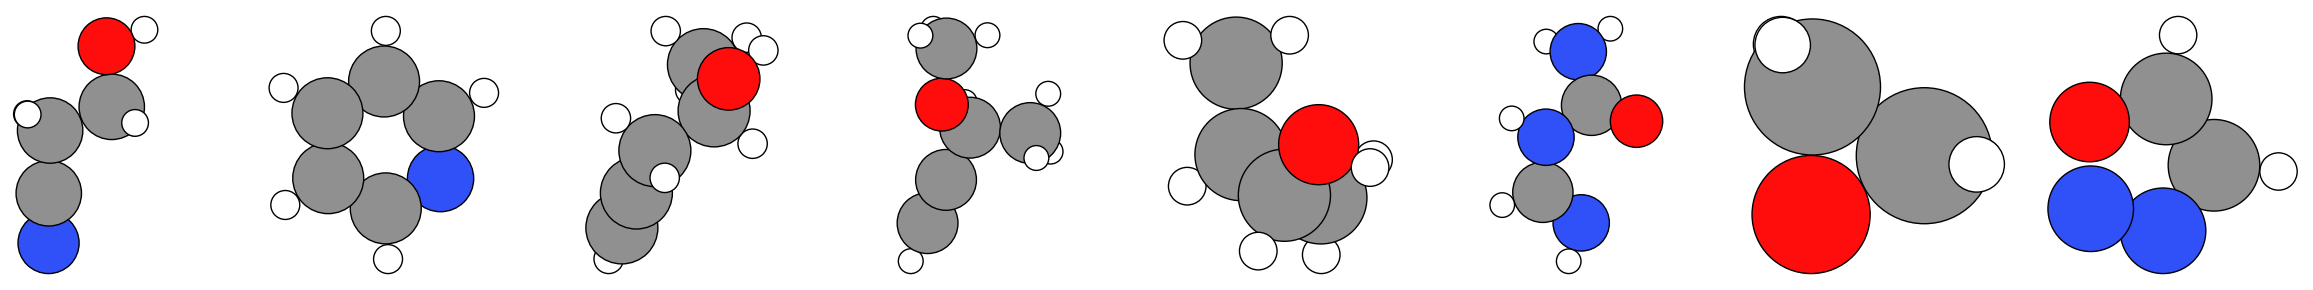

In [27]:
plot_batch_molecules(batch)

Diffuse the batch

In [28]:
# define the time step
t = 180

In [29]:
batch[properties.R], _ = diff_proc.diffuse(batch[properties.R], batch[properties.idx_m], t=torch.tensor(t))

In [30]:
# check if the centre of geometry for the molecules and sampled noise is zero
assert (scatter_mean(batch[properties.R], batch[properties.idx_m], batch[properties.n_atoms]) < 1e-5).all()

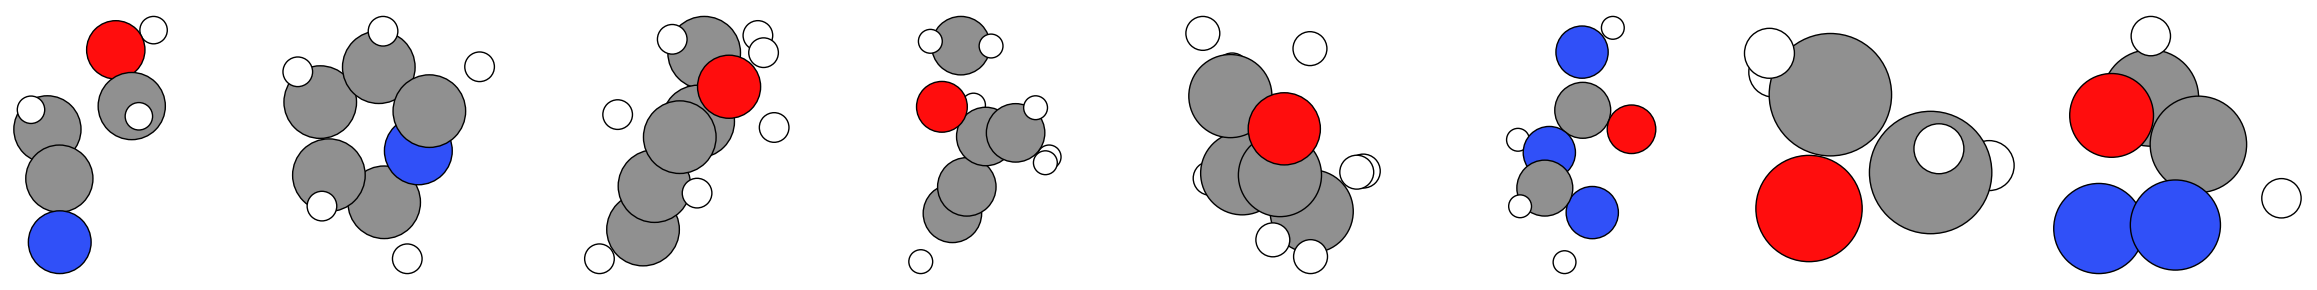

In [31]:
plot_batch_molecules(batch)

Denoise

In [32]:
# ddpm require time step as input
relaxed_ddpm, num_steps_ddpm, hist_ddpm = ddpm_sampler.denoise(batch, t=t)

# morered models dont need time step as input but max steps to interrupt the denoising process
relaxed_jt, num_steps_jt, hist_jt = mrd_jt_sampler.denoise(batch, max_steps=1000)
relaxed_as, num_steps_as, hist_as = mrd_as_sampler.denoise(batch, max_steps=1000)
relaxed_itp, num_steps_itp, hist_itp = mrd_itp_sampler.denoise(batch, max_steps=1000)

100%|██████████| 180/180 [00:05<00:00, 30.43it/s]
1000it [00:44, 22.32it/s]
1000it [01:30, 11.02it/s]
283it [00:14, 18.87it/s]


In [33]:
print("Num steps per example DDPM: ", num_steps_ddpm)
print("Num steps per example MoreRed-JT: ", num_steps_jt)
print("Num steps per example MoreRed-AS: ", num_steps_as)
print("Num steps per example MoreRed-ITP: ", num_steps_itp)

Num steps per example DDPM:  tensor([180, 180, 180, 180, 180, 180, 180, 180])
Num steps per example MoreRed-JT:  tensor([ -1,  -1, 445, 135,  -1,  -1,  -1,  -1])
Num steps per example MoreRed-AS:  tensor([ -1, 126,  -1,  -1,  -1,  -1,  -1,  -1])
Num steps per example MoreRed-ITP:  tensor([124, 181, 165, 141, 168, 157, 188, 283])


DDPM:


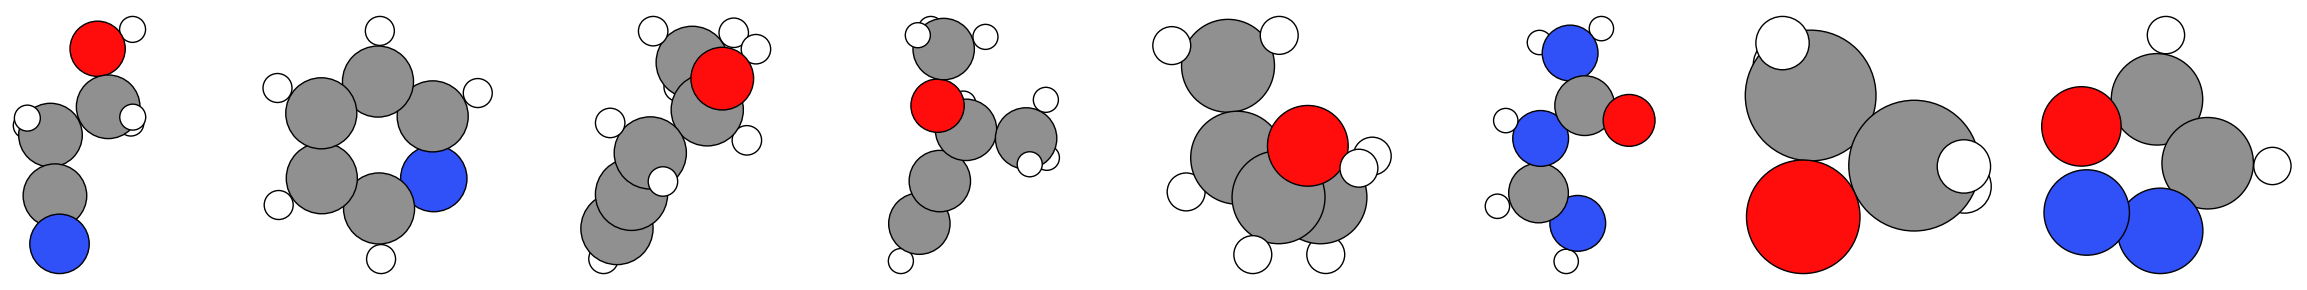

MoreRed-JT:


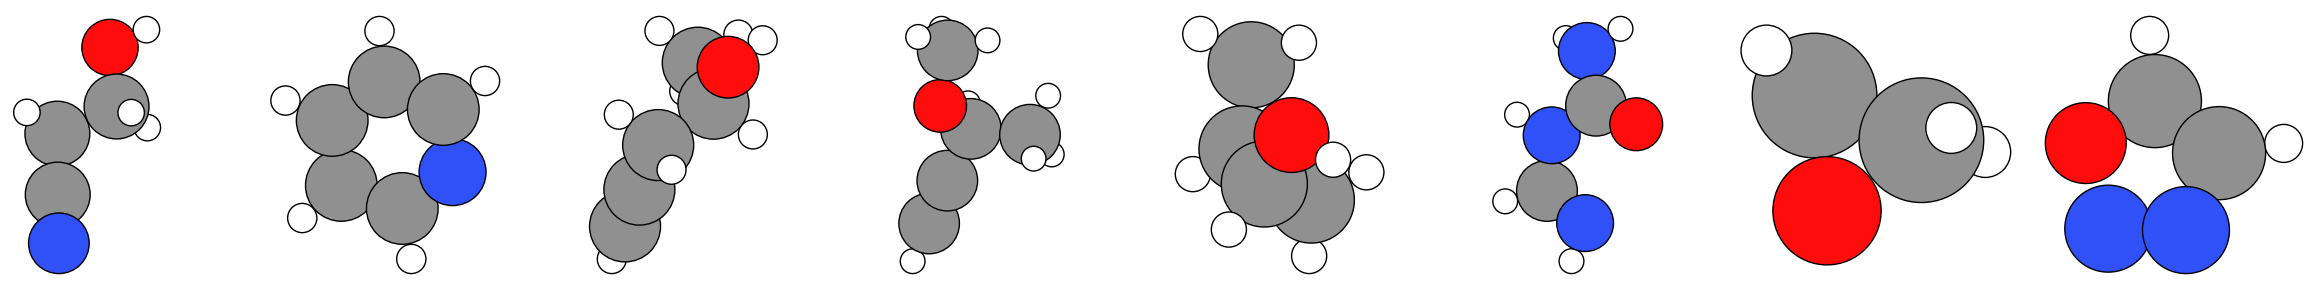

MoreRed-AS:


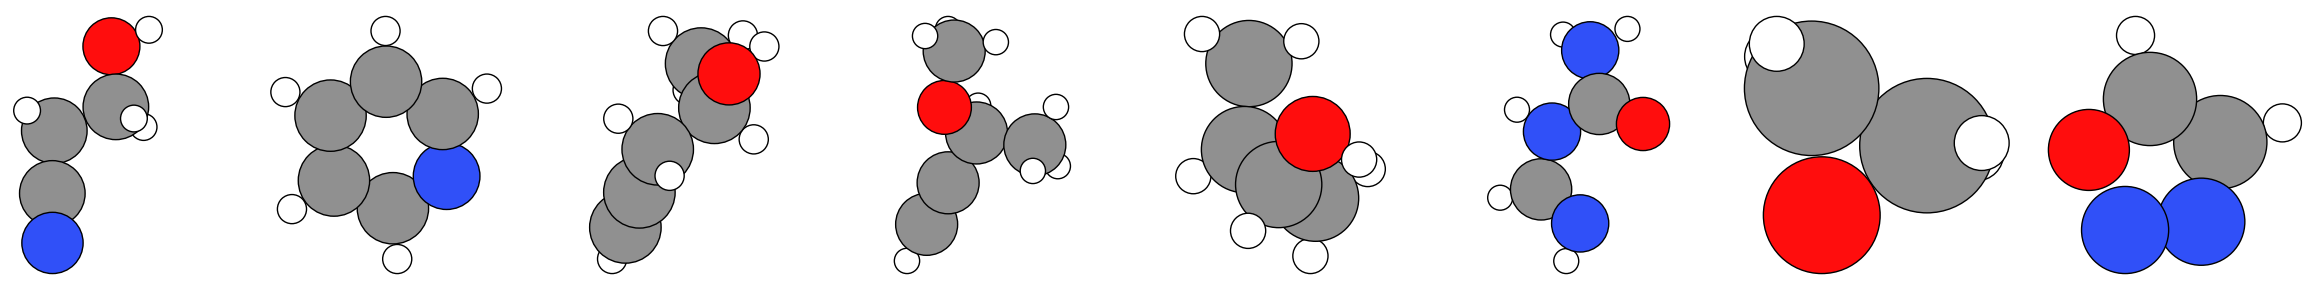

MoreRed-ITP:


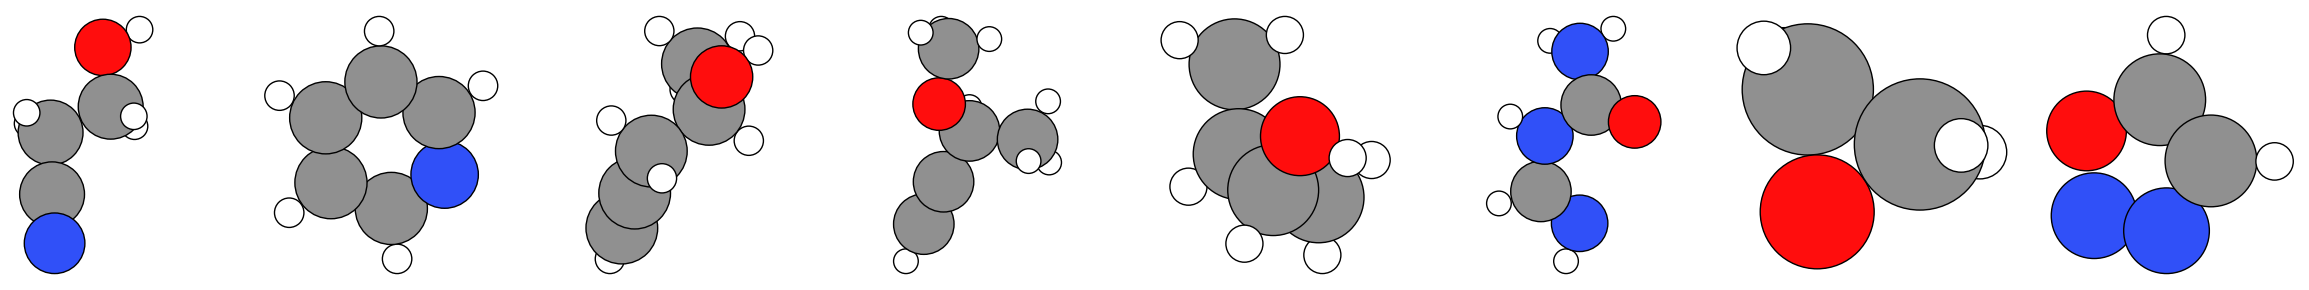

In [35]:
# plot the different examples
tmp_batch = {key: val.clone() for key, val in batch.items()}

print("DDPM:")
tmp_batch.update(relaxed_ddpm)
plot_batch_molecules(tmp_batch)

print("MoreRed-JT:")
tmp_batch.update(relaxed_jt)
plot_batch_molecules(tmp_batch)

print("MoreRed-AS:")
tmp_batch.update(relaxed_as)
plot_batch_molecules(tmp_batch)

print("MoreRed-ITP:")
tmp_batch.update(relaxed_itp)
plot_batch_molecules(tmp_batch)

In [37]:
# check validity of the molecules for each method
# Note this is just a simple check that can't e.g. recognize aromatic rings, check cG-SchNet Gebauer et al. for the analysis scripts

bonds_data = generate_bonds_data().values()

tmp_batch.update(relaxed_ddpm)
validity_ddpm = check_validity(tmp_batch, *bonds_data)
print("Validity DDPM: ", validity_ddpm['stable_molecules'])

tmp_batch.update(relaxed_jt)
validity_jt = check_validity(tmp_batch, *bonds_data)
print("Validity MoreRed-JT: ", validity_jt['stable_molecules'])

tmp_batch.update(relaxed_as)
validity_as = check_validity(tmp_batch, *bonds_data)
print("Validity MoreRed-AS: ", validity_as['stable_molecules'])

tmp_batch.update(relaxed_itp)
validity_itp = check_validity(tmp_batch, *bonds_data)
print("Validity MoreRed-ITP: ", validity_itp['stable_molecules'])

INFO:root:Bonds data already exists, skipping generation and reloading...
100%|██████████| 8/8 [00:00<00:00, 962.96it/s]


Validity DDPM:  [True, False, True, True, True, True, True, True]


100%|██████████| 8/8 [00:00<00:00, 2796.20it/s]


Validity MoreRed-JT:  [True, False, True, True, True, True, True, True]


100%|██████████| 8/8 [00:00<00:00, 1557.05it/s]


Validity MoreRed-AS:  [True, False, True, True, True, True, True, True]


100%|██████████| 8/8 [00:00<00:00, 2404.65it/s]

Validity MoreRed-ITP:  [True, False, True, True, True, True, True, True]


# Sample from scratch

Load a batch

In [38]:
batch = next(iter(data.train_dataloader()))

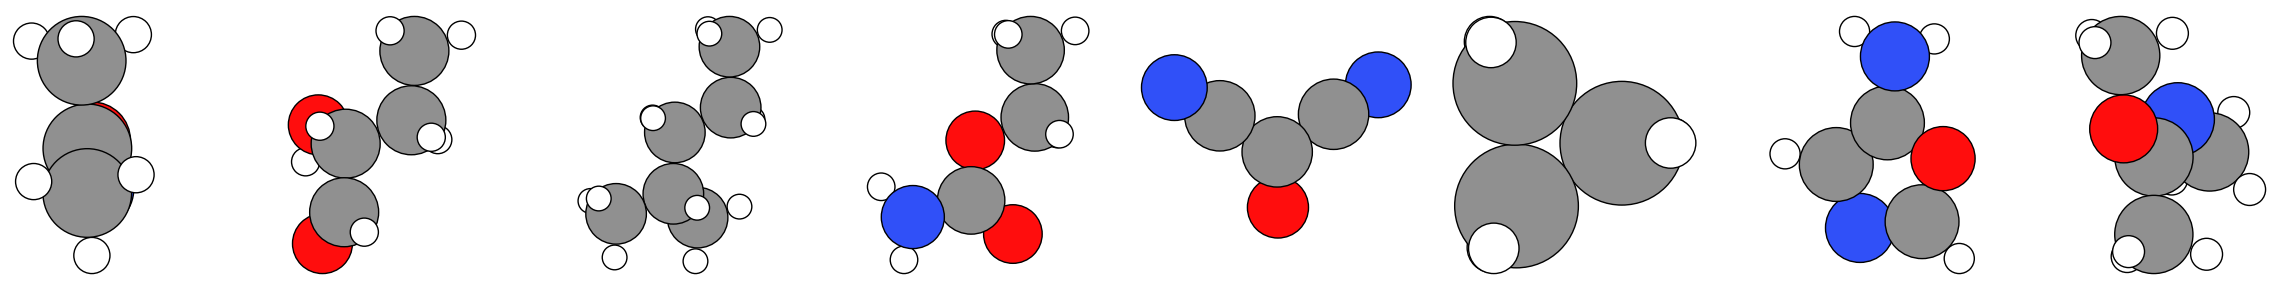

In [39]:
plot_batch_molecules(batch)

Sample random prior x_T from N(0,I)

In [51]:
t = None

In [52]:
x_T = ddpm_sampler.sample_prior(batch, t=None)

In [53]:
batch.update(x_T)

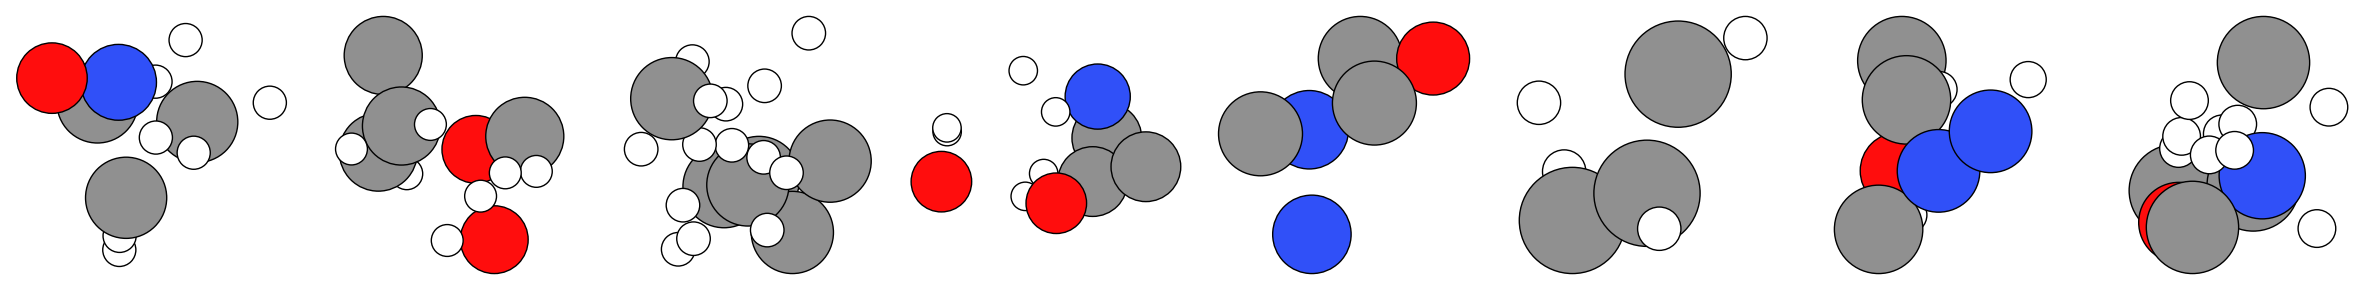

In [54]:
plot_batch_molecules(batch)

In [55]:
# check if the centre of geometry for the molecules and sampled noise is zero
assert (scatter_mean(batch[properties.R], batch[properties.idx_m], batch[properties.n_atoms]) < 1e-5).all()

In [56]:
samples_ddpm, num_steps_ddpm, hist_ddpm = ddpm_sampler.denoise(batch, t=t)

samples_jt, num_steps_jt, hist_jt = mrd_jt_sampler.denoise(batch, max_steps=2000)
samples_as, num_steps_as, hist_as = mrd_as_sampler.denoise(batch, max_steps=2000)
samples_itp, num_steps_itp, hist_itp = mrd_itp_sampler.denoise(batch, max_steps=2000)

100%|██████████| 1000/1000 [00:52<00:00, 19.11it/s]
2000it [02:01, 16.39it/s]
2000it [03:24,  9.77it/s]
881it [00:44, 19.65it/s]


In [210]:
batch.update(samples)

In [211]:
num_steps

tensor([  -1, 1667,   -1,   -1,   -1, 1142,   -1,  962])

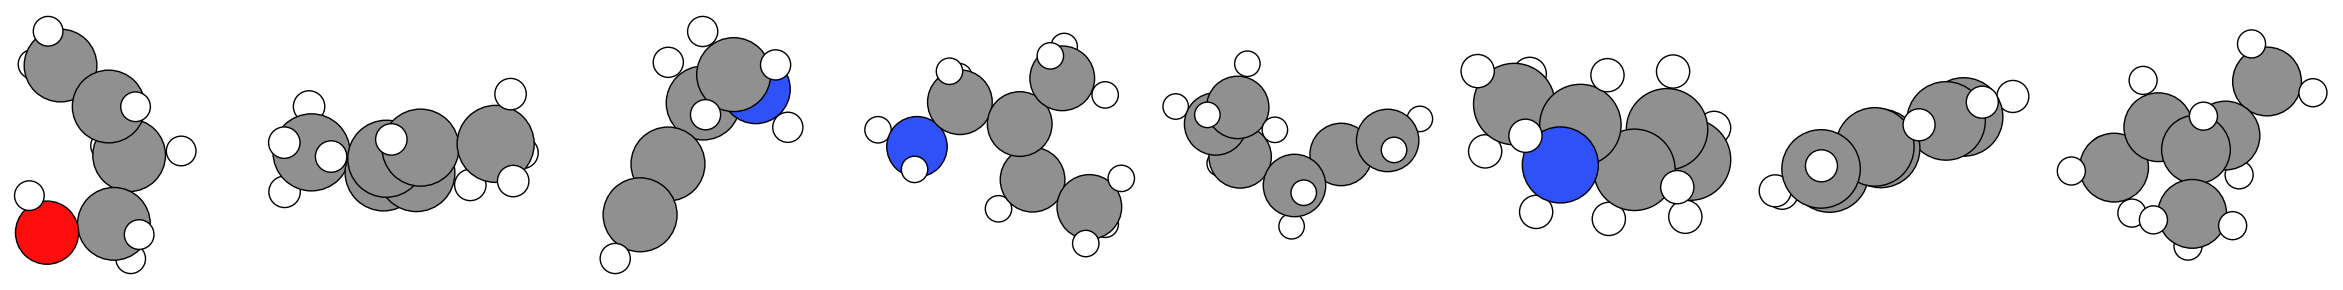

In [214]:
plot_batch_molecules(batch)

In [213]:
validity = check_validity(batch, *generate_bonds_data().values())
validity['stable_molecules'], validity['stable_molecules_wo_h']#, validity['connected'], validity['stable_atoms']

INFO:root:Bonds data already exists, skipping generation and reloading...
100%|██████████| 8/8 [00:00<00:00, 1814.54it/s]


([True, True, True, True, True, True, True, True],
 [True, True, True, True, True, True, True, True])

Save as xyz 

In [216]:
# get the trajectories of the stable molecules

trajectories = []
for m in tqdm(batch[properties.idx_m].unique()):
    trajectory = []
    if validity['stable_molecules'][m]:
        mask = batch[properties.idx_m] == m
        for i, h in enumerate(hist):
            if num_steps[m] > 0 and i > num_steps[m]:
                break
            mol = Atoms(numbers=batch[properties.Z][mask], positions=h[properties.R][mask])
            trajectory.append(mol)

        trajectories.append(trajectory[::-1])

100%|██████████| 8/8 [00:00<00:00, 15.15it/s]


In [218]:
# save one xzy per trajectory
path = "files/qm7x_sampling_traj"

for i, trajectory in enumerate(trajectories):
    # generate random number
    num = torch.randint(0, 10000, (1,)).item()

    ase.io.write(f"{path}/{len(trajectory)}_{num}.xyz", trajectory)

# Sample by manually using atomic numbers

Define the atomic numbers Z for p(X|Z)

In [117]:
Z = [
    torch.tensor([7, 6, 6, 7]),
    torch.tensor([6, 6, 1, 1]),
    torch.tensor([6, 8, 1, 1]),
]

Prepare the inputs

In [118]:
batch = sampler.prepare_inputs(Z)

In [119]:
batch.keys()

dict_keys(['_atomic_numbers', '_n_atoms', '_positions', '_cell', '_pbc', '_idx', '_idx_m'])

In [120]:
# check if the centre of geometry for the molecules and sampled noise is zero
assert (scatter_mean(batch[properties.R], batch[properties.idx_m], batch[properties.n_atoms]) < 1e-15).all()

In [121]:
x_T = sampler.sample_prior(batch, t=None)

In [122]:
batch.update(x_T)

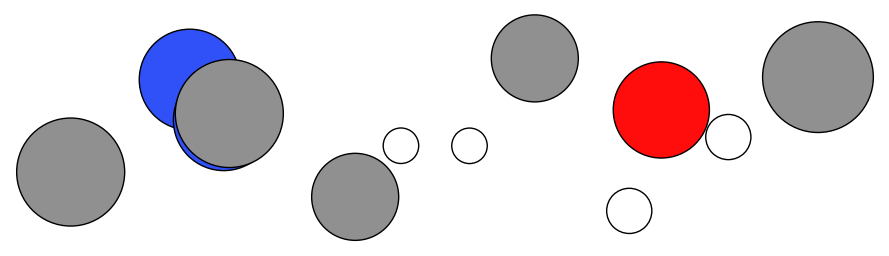

In [123]:
plot_batch_molecules(batch)

In [124]:
samples, num_steps, hist = sampler.denoise(batch, t=noise_schedule.T)

100%|██████████| 1000/1000 [00:05<00:00, 180.18it/s]


In [125]:
batch.update(samples)

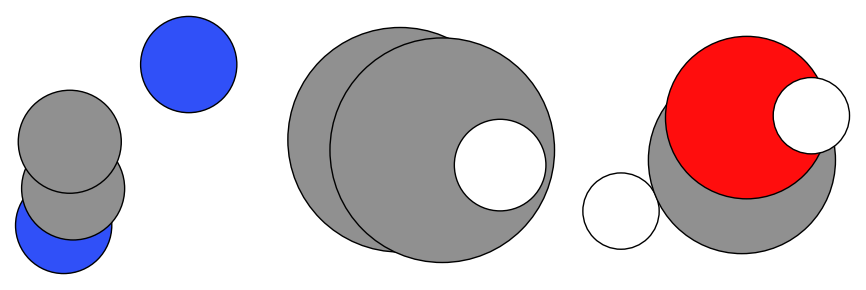

In [126]:
plot_batch_molecules(batch)

# Sampling History

In [144]:
time_steps = [
    scatter_mean(item["t"], batch[properties.idx_m], batch[properties.n_atoms]) 
                          for item in hist
]

In [145]:
time_steps[0].shape

torch.Size([3])

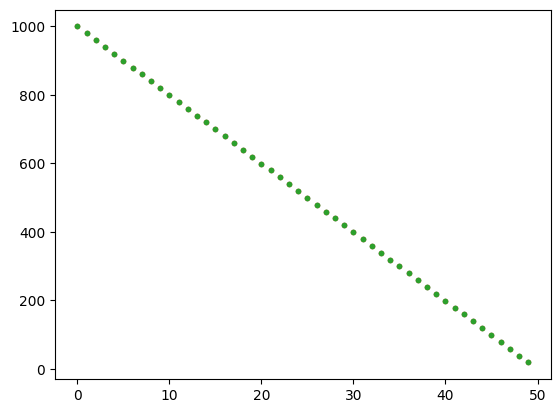

In [150]:
plt.plot(time_steps[::20], '.')
plt.show()

# Check validity

In [90]:
validity = check_validity(batch, *generate_bonds_data().values())

INFO:root:Bonds data already exists, skipping generation and reloading...
100%|██████████| 8/8 [00:00<00:00, 2338.45it/s]


In [91]:
validity['stable_molecules'], validity['stable_molecules_wo_h'], validity['connected'], validity['stable_atoms']

([True, True, True, True, True, True, False, False],
 [True, True, True, True, True, True, False, False],
 [True, True, True, True, True, True, False, True],
 [array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True]),
  array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True]),
  array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True]),
  array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True]),
  array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True]),
  array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True]),
  array([False,  True,  True, False,  True,  True,  True,  True,  True,